In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from curve_models import power_law, BrokenCurve
from tqdm.notebook import tqdm
import time
sns.set_style('white')
def calc_pct(pred_best, pred_worst, pred_curr):
    return (pred_worst - pred_curr)/(pred_worst - pred_best)

dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
gl_expmt = '0.1_5_False_uniform_30_0.5_0.5_5800_29000_290001'
ml_expmt = '0.1_5_False_uniform_30_0.5_0.5_20000_100000_1000001'
mltiny_expmt = '0.1_5_False_uniform_30_0.5_0.5_5250_21000_213973'
gltiny_expmt = '0.1_5_False_uniform_30_0.5_0.5_1880_9400_94001'

expmts = [('gl', gl_expmt), ('gl-tiny', gltiny_expmt), ('ml-20m-uniform', ml_expmt), ('ml-20m-tiny', mltiny_expmt)]
expmts = [('ml-20m-tiny', mltiny_expmt)]


In [39]:
for dataset_name, expmt in expmts:
    results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    all_test_mses = np.loadtxt(results_path + 'test_mses')
    all_macro_mses = np.load(results_path + 'macro_mses.npy')

    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_observable = data['n_observable'].iloc[0]
    results = []
    user_results = []
    n_runs = 1
    pcts_available = []

    for j in tqdm(range(n_runs)):
        worst_mse = data[data['run'] == j]['worst_mse'].iloc[0]
        best_mse = data[data['run'] == j]['best_mse'].iloc[0]
        ss = all_ss[j]
        mses = all_mses[j]
        test_mses = all_test_mses[j]
        macro_mses = all_macro_mses[j]
        n_pts = len(np.where(ss) > n_init)
        for i, (size, mse) in tqdm(enumerate(zip(ss, mses))):
            if size < n_init:
                continue
            if i == len(ss) -1:
                continue
            # this method fits a beginning power law curve and an end one
            pct_available = (size-n_init)/(n_observable-n_init)
            pcts_available.append(pct_available)
            true_pct = (worst_mse - mse)/(worst_mse - best_mse)
            
            slope_before = (mses[i] - mses[i-1])/(ss[i] - ss[i-1])
            slope_after = (mses[i+1] - mses[i])/(ss[i+1] - ss[i])
            true_slope = .5*(slope_before+slope_after)
            results.append({'pred_best': best_mse, 'pred_worst': worst_mse, 'pred_curr': mse,
                            'pred_pct': true_pct, 'true_curr': mse, 'cm': 'True',  
                            'pct_available': pct_available, 'run': j, 'slope':true_slope})
            
            broken = BrokenCurve(power_law, 'broken')
            broken.fit(ss[:i+1], mses[:i+1])

            pred_worst = broken.pred(n_init)
            pred_best = broken.pred(n_observable)
            pred_curr = broken.pred(size)
            slope = broken.slope(ss[i])
            pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
            
            results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                            'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'broken',  
                            'pct_available': pct_available, 'run': j, 'slope': slope})
            
            n_users = macro_mses.shape[1]
            now = time.time()
            all_times = []
            for k in tqdm(range(n_users)):
                all_times.append(time.time() - now)
                now=time.time()
                user_macro_mses = macro_mses[:,k]
                one = time.time() - now
               
                broken = BrokenCurve(power_law, 'broken')
                broken.fit(ss[:i+1], user_macro_mses[:i+1])
                
                macro_mse_delta = user_macro_mses[i+1] - user_macro_mses[i-1]
                size_delta = ss[i+1] - ss[i-1]
                true_user_slope = macro_mse_delta/size_delta 
                
                pred_worst = broken.pred(n_init)
                pred_best = broken.pred(n_observable)
                pred_curr = broken.pred(size)
                pred_user_slope = broken.slope(ss[i])
                pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
                true_pct = calc_pct(user_macro_mses[i], user_macro_mses[5], 
                                    user_macro_mses[-1])
                user_results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 
                                     'pred_curr': pred_curr, 'cm': 'broken',
                                     'pred_pct': pred_pct, 'pct_available': pct_available,
                                     'run': j, 'user': k, 'true_best': user_macro_mses[-1],
                                     'true_worst': user_macro_mses[5], 'slope': pred_user_slope,
                                     'true_pct': true_pct})
                
                user_results.append({'pred_best': user_macro_mses[-1], 
                                     'pred_worst': user_macro_mses[5], 
                                     'pred_curr': user_macro_mses[i], 'cm': 'True',
                                     'pred_pct': true_pct, 'true_best': user_macro_mses[-1],
                                     'true_worst': user_macro_mses[5], 'slope': true_user_slope,
                                     'true_pct': true_pct, 'pct_available': pct_available,
                                     'run': j, 'user': k})

    pd.DataFrame(results).to_csv('../results/forecasting/' + dataset_name + '/pred_performance')
    pd.DataFrame(user_results).to_csv('../results/forecasting/' + dataset_name + '/user_pred_performance')

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [40]:
dataset_name = 'ml-20m-tiny'
expmt = mltiny_expmt
results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
all_results = pd.read_csv('../results/forecasting/' + dataset_name + '/pred_performance')
user_results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/user_pred_performance')
data = pd.read_csv(results_path + 'results_df')
all_ss = np.loadtxt(results_path + 'sample_sizes')
all_mses = np.loadtxt(results_path + 'mses')
all_test_mses = np.loadtxt(results_path + 'test_mses')
all_macro_mses = np.load(results_path + 'macro_mses.npy')

In [41]:
n_init = data['n_init'].iloc[0]
n_observable = data['n_observable'].iloc[0]
pcts_available = []
run = 0
ss = all_ss[run]
mses = all_mses[run]
for i, (size, mse) in tqdm(enumerate(zip(ss, mses))):

    # this method fits a beginning power law curve and an end one
    pct_available = (size-n_init)/(n_observable-n_init)
    pcts_available.append(pct_available)
pcts_available = np.around(pcts_available, 4)
pcts_available

array([-0.1183, -0.0937, -0.0691, -0.0445, -0.02  ,  0.0046,  0.0292,
        0.0538,  0.0784,  0.1029,  0.1275,  0.1521,  0.1767,  0.2013,
        0.2259,  0.2504,  0.275 ,  0.2996,  0.3242,  0.3488,  0.3733,
        0.3979,  0.4225,  0.4471,  0.4717,  0.4962,  0.5208,  0.5454,
        0.57  ,  0.5946,  0.6191,  0.6437,  0.6683,  0.6929,  0.7175,
        0.742 ,  0.7666,  0.7912,  0.8158,  0.8404,  0.8649,  0.8895,
        0.9141,  0.9387,  0.9633,  0.9878])

Text(0.5, 0.98, 'Distribution of $p_u$ \n [Global Performance Curves]')

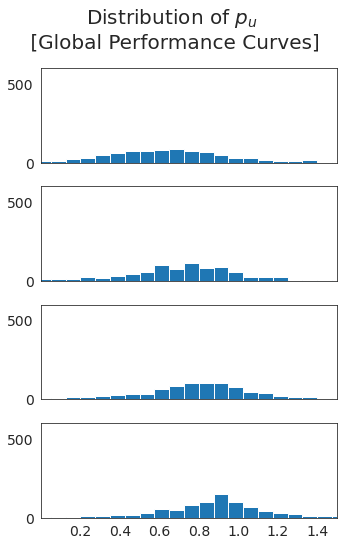

In [42]:
fig, axs = plt.subplots(4, 1, figsize=(5, 8), sharey=True, sharex=True)
g_opts = [.6, .7, .8, .9]
n_users = all_macro_mses.shape[2]
n_runs = 1
for j, g in enumerate(g_opts):
    gg = all_results[all_results['pred_pct'] > g]
    gg = gg.sort_values('pred_pct').groupby(['cm', 'run']).first().reset_index()
    pct_collected =  np.around(gg['pct_available'], 4).iloc[0]
    stop_idx = np.where(pcts_available == np.around(pct_collected, 4))[0]
    #stop_idx = np.min(np.where(np.around(pcts_available, 4) == pct_collected)[0])
    user_pcts = []
    for k in range(n_runs):
        for i in range(n_users):
            worst_mse = all_macro_mses[k,5,i]
            best_mse = all_macro_mses[k,-1,i]
            curr_mse = all_macro_mses[k,stop_idx,i]
            user_pcts.append((worst_mse - curr_mse)/(worst_mse - best_mse))
    user_pcts = np.array(user_pcts)
    ax = axs[j]
    ax.hist(user_pcts, range=(-1, 2), bins=40)
    #ax.set_title("g = " + str(g))
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 600)
    ax.set_yticks([0, 500])
    ax.set_xticks([.2, .4, .6, .8, 1.0, 1.2, 1.4])

    #ax.set_ylabel("# of Users")
    ax.set_xlabel("")
    if j != 0:
        ax.set_ylabel("")
#fig.text(0.5, 0.03, r"$p_u$", ha='center')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.suptitle(r"Distribution of $p_u$" + " \n [Global Performance Curves]")


In [43]:
dataset_name = 'ml-20m-tiny'
user_results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/user_pred_performance')
expmt = '5_False_0.1_0.4_uniform_21000_5250_0_30_1_213973_0.5_0.5_0_0.85'
results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
all_macro_mses = np.load(results_path + 'macro_mses.npy')
all_ss = np.loadtxt(results_path + 'sample_sizes')
pcts_available = np.around(sorted(set(user_results_df['pct_available'])),4)

990
977
953
918


Text(0.5, 0.98, 'Distribution of $p_u$\n[User Performance Curves]')

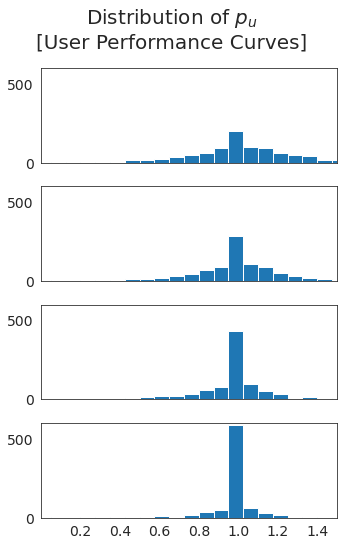

In [68]:
fig, axs = plt.subplots(4, 1, figsize=(5, 8), sharey=True, sharex=True)
g_opts = [.6, .7, .8, .9]
pcts_available = 
user_sets = []
for i, g in enumerate(g_opts):
    ax = axs[i]
    gg = user_results_df[user_results_df['pred_pct'] > g]
    gg = gg[gg['cm'] == 'broken']
    gg_run = gg.sort_values('pred_pct').groupby(['run', 'user']).first().reset_index()
    
    #gg_run = gg[(gg['true_pct'] > 0) &  (gg['true_pct'] <= 1)]
    #gg_run = gg_run[gg_run['user'].isin(users)]
    #user_sets.append(set(gg_run['user']))
    print(len(gg_run))
    ax.hist(gg_run['true_pct'], range=(-1, 2), bins=40)
    #ax.set_title("g = " + str(g))
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 600)
    ax.set_yticks([0, 500])
    ax.set_xticks([.2, .4, .6, .8, 1.0, 1.2, 1.4])

    ax.set_xlabel("")
    if j != 0:
        ax.set_ylabel("")
#fig.text(0.5, 0.03, '$p_u$', ha='center')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.suptitle(r"Distribution of $p_u$" + "\n[User Performance Curves]")


## Diminishing Returns Criterion

Text(0.5, 0.98, 'Distribution of $p_u$ \n [Global Performance Curves]')

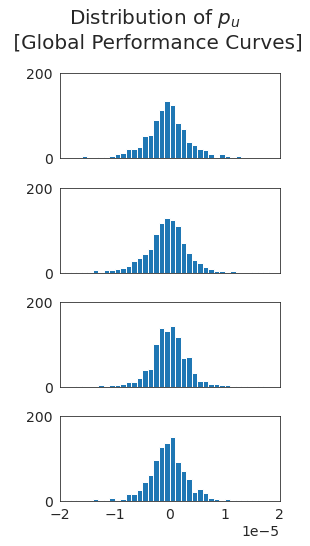

In [76]:
fig, axs = plt.subplots(4, 1, figsize=(4, 8), sharey=True, sharex=True)
t_opts = [-.5e-6,  -.3e-6, -.2e-6,-.1e-6]
n_users = all_macro_mses.shape[2]
n_runs = 1
for j, t in enumerate(t_opts):
    gg = all_results[all_results['slope'] > t]
    gg = gg.sort_values('pct_available').groupby(['cm', 'run']).first().reset_index()
    broken_gg = gg[gg['cm'] == 'broken']
    pct_collected =  np.around(broken_gg['pct_available'], 4).iloc[0]
    stop_idx = np.where(pcts_available == pct_collected)[0]
    user_slopes = []
    for k in range(n_runs):
        for i in range(n_users):
            worst_mse = all_macro_mses[k,5,i]
            best_mse = all_macro_mses[k,-1,i]
            curr_mse = all_macro_mses[k,stop_idx,i]
            macro_mse_delta = all_macro_mses[k,stop_idx-1,i] - all_macro_mses[k,stop_idx+1,i]
            size_delta = all_ss[k,stop_idx-1] - all_ss[k,stop_idx+1]
            user_slope = macro_mse_delta/size_delta
            # calculate current slope of user_pcts
#             print(all_macro_mses[k,stop_idx-1,i])
#             print(macro_mse_delta, size_delta, user_slope)
            user_slopes.append(user_slope)
    user_slopes = np.array(user_slopes)
    ax = axs[j]
    ax.hist(user_slopes, range=(-2e-5, 2e-5), bins=40)
    #ax.set_title("g = " + str(g))
    ax.set_xlim(-2e-5, 2e-5)
    ax.set_ylim(0, 200)
    ax.set_yticks([0, 200])
    #ax.set_xticks([.2, .4, .6, .8, 1.0, 1.2, 1.4])

    #ax.set_ylabel("# of Users")
    ax.set_xlabel("")
    if j != 0:
        ax.set_ylabel("")
#fig.text(0.5, 0.03, r"$p_u$", ha='center')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.suptitle(r"Distribution of $p_u$" + " \n [Global Performance Curves]")


(array([2.0000e+00, 5.0000e+00, 7.0000e+00, 5.1000e+01, 3.5000e+02,
        6.0520e+03, 6.6096e+04, 7.1600e+03, 2.5500e+02, 2.2000e+01]),
 array([-6.63308956e-05, -5.62621681e-05, -4.61934405e-05, -3.61247130e-05,
        -2.60559854e-05, -1.59872579e-05, -5.91853030e-06,  4.15019725e-06,
         1.42189248e-05,  2.42876524e-05,  3.43563799e-05]),
 <BarContainer object of 10 artists>)

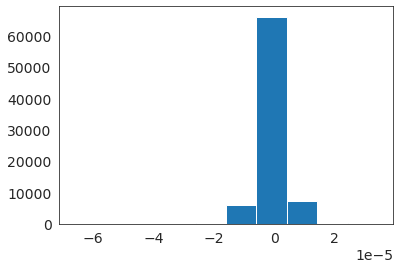

In [58]:
plt.hist(user_results_df['slope'])

1000
1000
1000
1000


Text(0.5, 0.98, 'Distribution of $p_u$\n[User Performance Curves]')

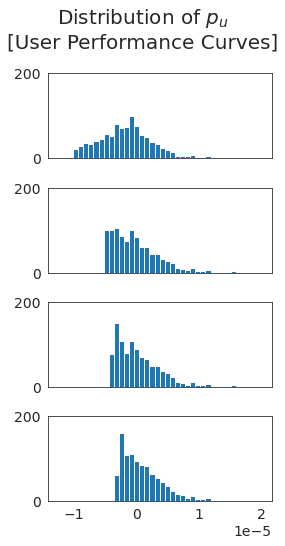

In [74]:
fig, axs = plt.subplots(4, 1, figsize=(4, 8), sharey=True, sharex=True)
t_opts = [-.10e-4, -.05e-4, -.04e-4, -.03e-4]
user_sets = []
for i, t in enumerate(t_opts):
    ax = axs[i]
    gg = user_results_df[user_results_df['slope'] > t]
    gg = gg[gg['cm'] == 'broken']
    print(len(set(gg['user'])))
    gg_run = gg.sort_values('pct_available').groupby(['run', 'user']).first().reset_index()
    
    #gg_run = gg[(gg['true_pct'] > 0) &  (gg['true_pct'] <= 1)]
    #gg_run = gg_run[gg_run['user'].isin(users)]
    #user_sets.append(set(gg_run['user']))
    ax.hist(gg_run['slope'], range=(-1.25e-5, 2e-5), bins=40)
    #ax.set_title("g = " + str(g))
    ax.set_ylim(0, 200)
    ax.set_yticks([0, 200])
#     ax.set_xticks([.2, .4, .6, .8, 1.0, 1.2, 1.4])

    ax.set_xlabel("")
    if j != 0:
        ax.set_ylabel("")
#fig.text(0.5, 0.03, '$p_u$', ha='center')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.suptitle(r"Distribution of $p_u$" + "\n[User Performance Curves]")


In [ ]:
users = list(set.intersection(*user_sets))

In [ ]:
# 20% of users have a worse per-user MSE given all data than at the beginning

In [ ]:
sns.lineplot(x='pct_available', y='pred_pct', hue='cm', 
             data=user_results_df[user_results_df['run'] == 0])


In [ ]:
sns.lineplot(x='pct_available', y='pred_best', hue='cm', 
             data=user_results_df[user_results_df['run'] == 0])


In [ ]:
gg = user_results_df[user_results_df['user'] == 10]
gg = gg[gg['run'] == 2]
sns.lineplot(x='pct_available', y='pred_best', hue='cm', 
             data=gg)


In [ ]:
# Plot the distribution of user curves for a given macro_mse curve
m_mse_df = []
for i in range(5):
    for j in range(1000):
        for k in range(46):
            mse = all_macro_mses[i, k, j]
            m_mse_df.append({'run': i, 'user': j, 'ss': all_ss[i][k], 'mse': mse})
m_mse_df = pd.DataFrame(m_mse_df)

In [ ]:
sns.lineplot(x='ss', y='mse', data=m_mse_df)
plt.xlabel("Sample size")
plt.ylabel("User MSE")
plt.title("User MSEs over Data Collection")

In [ ]:
plt.plot(all_ss[0], all_macro_mses[0,:,20])

In [ ]:
# can report errors over runs, or over users...over users is a much larger spread.
#one_user = user_results_df[user_results_df['user'] == 1]
first_run = user_results_df[user_results_df['run'] == 0]
# Plot evolution of best performance prediction
sns.lineplot(x='pct_available', y='pred_curr', hue='cm', data=first_run)

In [ ]:
f